# Investigating the effect of patient features by varying feature values in artificial patients

## Plain English summary

In this notebook we start with a 'base patient' who has features that are favourable to use of thrombolysis:

* Onset to arrival = 80 mins
* Arrival to scan = 20 mins
* Infarction = 1 
* NIHSS = 15
* Prior disability level = 0
* Precise onset time = 1
* Use of AF anticoagulents = 0

We then vary the following features in turn, keeping all other features the same as the base patient:

* NIHSS = 0-40
* Prior disability level = 0-5
* Precise onset time = 0-1

Perceived reasons to *not* give thrombolysis appear more than additive - many hopsitals will accept one marginal reason not to give thrombolysis, but the combination of marginal reasons have a large effect than if these reasons were all considered independently.

## Model and data

XGBoost model was trained on all of the data (no test set used). The 10 features in the model are:

* Arrival-to-scan time: Time from arrival at hospital to scan (mins)
* Infarction: Stroke type (1 = infarction, 0 = haemorrhage)
* Stroke severity: Stroke severity (NIHSS) on arrival
* Precise onset time: Onset time type (1 = precise, 0 = best estimate)
* Prior disability level: Disability level (modified Rankin Scale) before stroke
* Stroke team: Stroke team attended
* Use of AF anticoagulents: Use of atrial fibrillation anticoagulant (1 = Yes, 0 = No)
* Onset-to-arrival time: Time from onset of stroke to arrival at hospital (mins)
* Onset during sleep: Did stroke occur in sleep?
* Age: Age (as middle of 5 year age bands)

And one target feature:

* Thrombolysis: Recieve thrombolysis (1 = Yes, 0 = No)

The 10 features included in the model (to predict whether a patient will recieve thrombolysis) were chosen sequentially as having the single best improvement in model performance (using the ROC AUC). The stroke team feature is included as a one-hot encoded feature.

## Observations

The number of hospitals giving thrombolysis:

* Base patient: 132 (99%)
* Base patient, but NIHSS = 5: 123 (93%)
* Base patient, but pre-stroke disability = 2: 125 (95%)
* Base patient, but estimated stroke onset time: 109 (83%)

Combining two marginal features:

* Base patient, but NIHSS = 5 and pre-stroke disability = 2: 78 (59%)
* Base patient, but NIHSS = 5 and estimated stroke onset time: 30 (23%)
* Base patient, but pre-stroke disability = 2 and estimated stroke onset time: 26 (20%)

Combining three marginal features:

* Base patient, but NIHSS = 5, pre-stroke disability = 2, estimated stroke onset time: 2 (1.5%)

## Import libraries

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import importlib
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import shap

from scipy import stats

from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.linear_model import LinearRegression

from xgboost import XGBClassifier
import json
import pickle

# Import local package
from utils import waterfall
# Force package to be reloaded
importlib.reload(waterfall);

## Set filenames

In [2]:
number_key_features = 10
model_text = f'xgb_{number_key_features}_features'
notebook = '20_synthetic'

## Create output folders if needed

In [3]:
path = './output'
if not os.path.exists(path):
    os.makedirs(path)
    
path = './predictions'
if not os.path.exists(path):
    os.makedirs(path)

## Read in JSON file
Contains a dictionary for plain English feature names for the 8 features selected in the model. Use these as the column titles in the DataFrame.

In [4]:
with open("./output/01_feature_name_dict.json") as json_file:
    dict_feature_name = json.load(json_file)

## Load data

In [5]:
synthetic = pd.read_csv('./synthetic/synthetic_10_features.csv')

# Get list of hopsitals
hospitals = list(synthetic['Stroke team'])

# Show first instance
synthetic.iloc[0]

Arrival-to-scan time                20
Infarction                           1
Stroke severity                     15
Precise onset time                   1
Prior disability level               0
Stroke team                 AGNOF1041H
Use of AF anticoagulents             0
Onset-to-arrival time               80
Onset during sleep                   0
Age                               72.5
Name: 0, dtype: object

## Load XGBoost model

Load the XGBoost model that was trained on the 10k cohort train/test dataset (in notebook 04_compare_10k_cohort_key_features.ipynb).

In [6]:
# Keep copy of original, with 'Stroke team' not one-hot encoded
X = synthetic.copy(deep=True)

# One-hot encode 'Stroke team'
X_hosp = pd.get_dummies(X['Stroke team'], prefix = 'team')
X = pd.concat([X, X_hosp], axis=1)
X.drop('Stroke team', axis=1, inplace=True)


# Load models
filename = (f'./saved_models/04_{model_text}_10k_cohort.p')
with open(filename, 'rb') as filehandler:
    model = pickle.load(filehandler)

##  Get predictions for each hospital

In [7]:
# Get predicted probabilities and class
y_prob = model.predict_proba(X)[:,1]
y_pred = y_prob > 0.5

Store predictions for each hospital in data frame

In [8]:
stroke_team = synthetic['Stroke team']
probs = model.predict_proba(X)[:, 1]
results = pd.DataFrame()
results['Stroke team'] = stroke_team
results['Probability'] = probs
results['Thrombolyse'] = probs >= 0.5
results['Index'] = np.arange(len(results))
results.head()

,Stroke team,Probability,Thrombolyse,Index
0,AGNOF1041H,0.910372,True,0
1,AKCGO9726K,0.804502,True,1
2,AOBTM3098N,0.820828,True,2
3,APXEE8191H,0.883750,True,3
4,ATDID5461S,0.916139,True,4


Plot probabilities of receiving thrombolysis in descending order

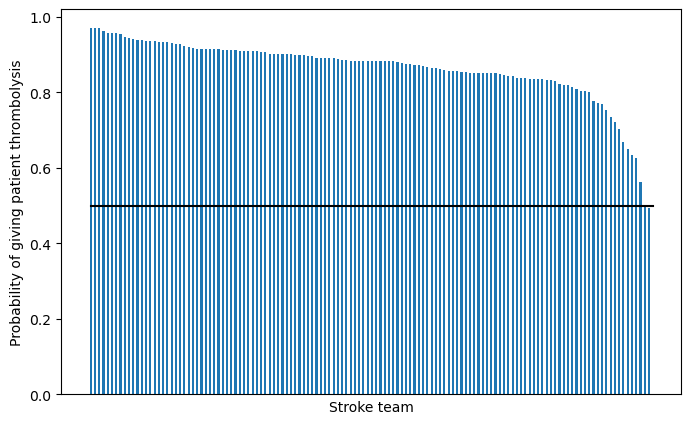

In [9]:
sorted_results = results.sort_values('Probability', ascending=False)

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot()
x_chart = range(len(results))
ax.bar(x_chart, sorted_results['Probability'], width=0.5)
ax.plot([0, len(results)], [0.5, 0.5], c='k')
ax.axes.get_xaxis().set_ticks([])
ax.set_xlabel('Stroke team')
ax.set_ylabel('Probability of giving patient thrombolysis')
plt.savefig(f'./output/{notebook}_probs_thrombolysis.jpg', dpi=300)
plt.show()

## Show SHAP waterfall plots for hopsitals with high, mediam, and low propensity to use thrombolysis

Load the SHAP explainer model (this was set up using the model and feature values from training set). To be used later to create waterfall plots.

In [10]:
# Set up method to estimate SHAP values for tree models and ensembles of trees
filename = (f'./output/03a_{model_text}_shap_explainer_object_probability.p')

# Load SHAP explainer
with open(filename, 'rb') as filehandler:
    explainer_probability = pickle.load(filehandler)

In [11]:
# Get index of highest probability team
index_high = sorted_results.iloc[0]['Index']
index_mid = sorted_results.iloc[int(len(sorted_results)/2)]['Index']
index_low = sorted_results.iloc[-1]['Index']

In [12]:
# Get Shapley values along with base and features
shap_values_probability_extended = explainer_probability(X)
# Shap values exist for each classification in a Tree
shap_values_probability = shap_values_probability_extended.values

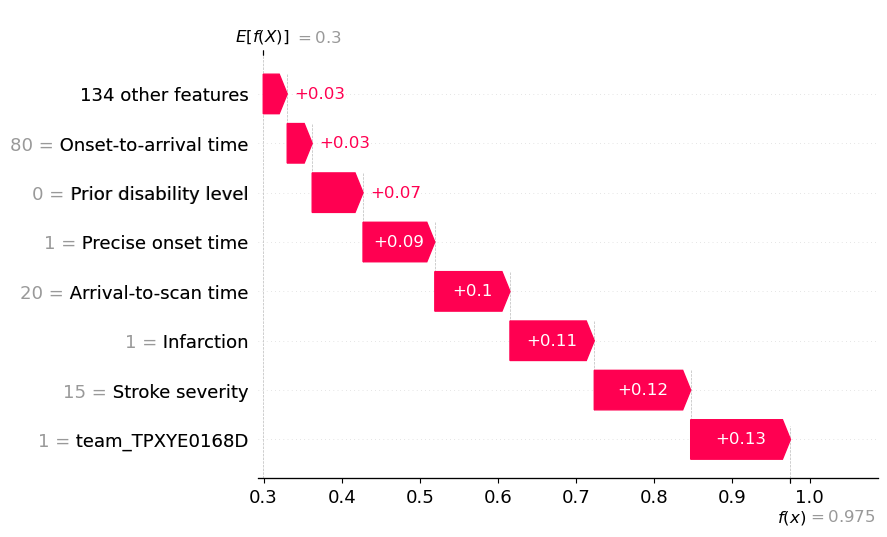

In [13]:
fig = waterfall.waterfall(
                shap_values_probability_extended[index_high],
                show=False, max_display=8, y_reverse=True)
plt.savefig(f'./output/{notebook}_waterfall_probs_high.jpg', dpi=300, bbox_inches='tight', pad_inches=0.2)
plt.show()

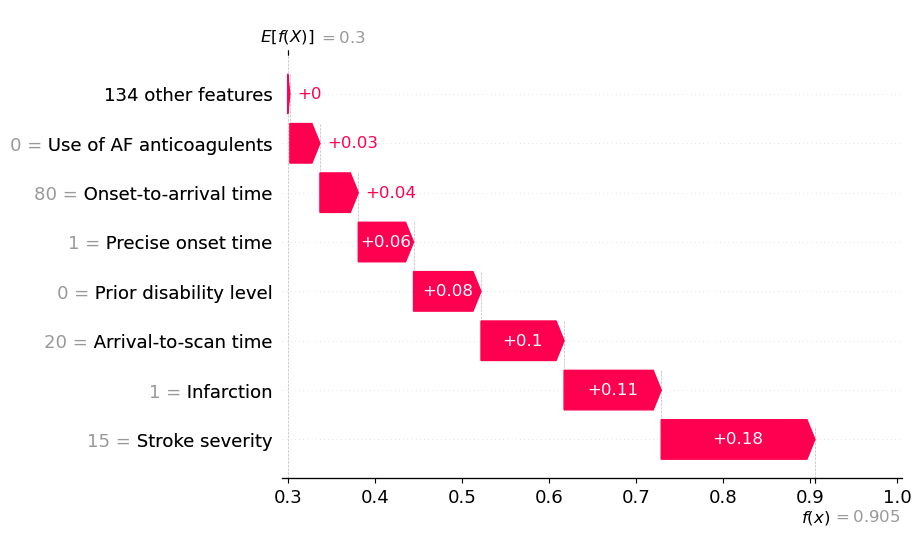

In [14]:
fig = waterfall.waterfall(
                shap_values_probability_extended[index_mid],
                show=False, max_display=8, y_reverse=True)
plt.savefig(f'./output/{notebook}_probs_medium.jpg', dpi=300, bbox_inches='tight', pad_inches=0.2)
plt.show()

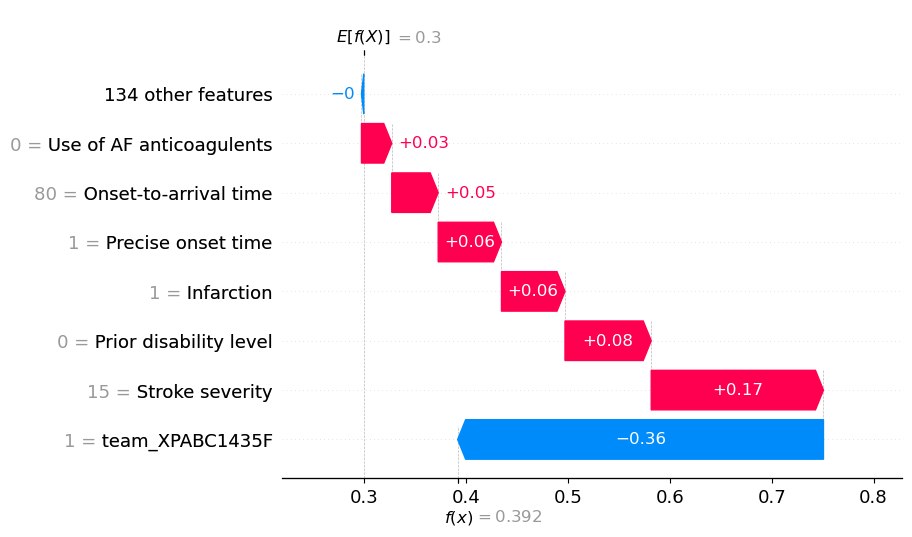

In [15]:
fig = waterfall.waterfall(
                shap_values_probability_extended[index_low],
                show=False, max_display=8, y_reverse=True)
plt.savefig(f'./output/{notebook}_probs_low.jpg', dpi=300, bbox_inches='tight', pad_inches=0.2)
plt.show()

## Predict thrombolysis with varying patient features

The base patient has the following values:

* Onset to arrival = 80 mins
* Arrival to scan = 20
* Infaction = 1 
* NIHSS = 15
* Prior disability level = 0
* Precise onset time = 1
* Use of AF anticoagulents = 0

We then vary the following features in turn, keeping all other features the same as the base patient:

* NIHSS = 0-40
* Prior disability level = 0-5
* Precise onset time = 0-1

In [16]:
# Keep copy of original, with 'Stroke team' not one-hot encoded
X_synthetic = X.copy(deep=True)

# Adjust NIHSS
number_thrombolysing_NIHSS = []
for stroke_sev in range(41):
    X_adjusted = X_synthetic.copy()
    X_adjusted['Stroke severity'] = stroke_sev
    y_prob = model.predict_proba(X_adjusted)[:,1]
    y_pred = y_prob > 0.5
    number_thrombolysing_NIHSS.append(y_pred.sum())

# Adjust Prior disability
number_thrombolysing_mrs = []
for mrs in range(6):
    X_adjusted = X_synthetic.copy()
    X_adjusted['Prior disability level'] = mrs
    y_prob = model.predict_proba(X_adjusted)[:,1]
    y_pred = y_prob > 0.5
    number_thrombolysing_mrs.append(y_pred.sum())

# Adjust precise onset time
number_thrombolysing_precise_onset = []
for precise_onset in [0,1]:
    X_adjusted = X_synthetic.copy()
    X_adjusted['Precise onset time'] = precise_onset
    y_prob = model.predict_proba(X_adjusted)[:,1]
    y_pred = y_prob > 0.5
    number_thrombolysing_precise_onset.append(y_pred.sum())

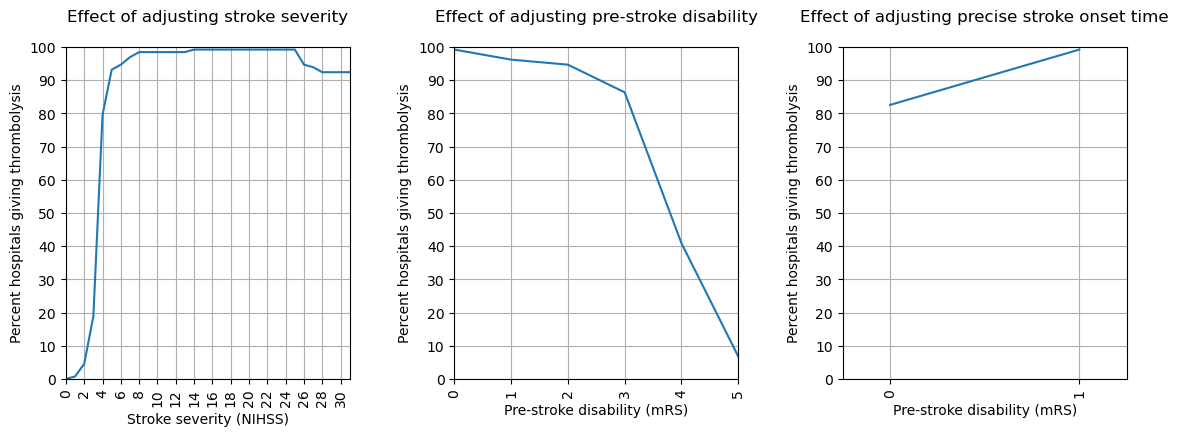

In [17]:
fig = plt.figure(figsize=(12,5))
number_hopsitals = len(hospitals)

ax1 = fig.add_subplot(1,3,1)
x1 = range(len(number_thrombolysing_NIHSS))
y1 = (np.array(number_thrombolysing_NIHSS) / number_hopsitals) * 100
ax1.plot(x1, y1)
ax1.set_xlabel('Stroke severity (NIHSS)')
ax1.set_ylabel('Percent hospitals giving thrombolysis')
ax1.set_xticks(np.arange(0,31,2))
ax1.set_xticklabels(ax1.get_xticks(), rotation = 90)
ax1.set_yticks(np.arange(0,101,10))
ax1.set_ylim(0,100)
ax1.set_xlim(0,31)
ax1.set_title('Effect of adjusting stroke severity\n')
ax1.grid()

ax2 = fig.add_subplot(1,3,2)
x2 = range(len(number_thrombolysing_mrs))
y2 = (np.array(number_thrombolysing_mrs) / number_hopsitals) * 100
ax2.plot(x2, y2)
ax2.set_xlabel('Pre-stroke disability (mRS)')
ax2.set_ylabel('Percent hospitals giving thrombolysis')
ax2.set_xticks(range(6))
ax2.set_xticklabels(ax2.get_xticks(), rotation = 90)
ax2.set_yticks(np.arange(0,101,10))
ax2.set_ylim(0,100)
ax2.set_xlim(0,5)
ax2.set_title('Effect of adjusting pre-stroke disability\n')
ax2.grid()

ax3 = fig.add_subplot(1,3,3)
x3 = range(len(number_thrombolysing_precise_onset))
y3 = (np.array(number_thrombolysing_precise_onset) / number_hopsitals) * 100
ax3.plot(x3, y3)
ax3.set_xlabel('Pre-stroke disability (mRS)')
ax3.set_ylabel('Percent hospitals giving thrombolysis')
ax3.set_xticks(range(2))
ax3.set_xticklabels(ax3.get_xticks(), rotation = 90)
ax3.set_yticks(np.arange(0,101,10))
ax3.set_ylim(0,100)
ax3.set_xlim(-0.25, 1.25)
ax3.set_title('Effect of adjusting precise stroke onset time\n')
ax3.grid()

plt.tight_layout(pad=3)
plt.savefig(f'./output/{notebook}_{model_text}_IVT_rate_vs_feature_values.jpg', 
            dpi=300)
plt.show()

## Show interactions between features

Stroke severity (NIHSS) = 5

In [18]:
X_adjusted = X_synthetic.copy()
X_adjusted['Stroke severity'] = 5
y_prob = model.predict_proba(X_adjusted)[:,1]
y_pred = y_prob > 0.5
percent = y_pred.mean()*100
count = y_pred.sum()
print (f'Number of hospitals giving thrombolysis: {count}')
print (f'Percent of hospitals that would give thrombolsysis: {percent:.1f}')

Number of hospitals giving thrombolysis: 123
Percent of hospitals that would give thrombolsysis: 93.2


Prior disability level (mRS) = 2

In [19]:
X_adjusted = X_synthetic.copy()
X_adjusted['Prior disability level'] = 2

y_prob = model.predict_proba(X_adjusted)[:,1]
y_pred = y_prob > 0.5
percent = y_pred.mean()*100
count = y_pred.sum()
print (f'Number of hospitals giving thrombolysis: {count}')
print (f'Percent of hospitals that would give thrombolsysis: {percent:.1f}')

Number of hospitals giving thrombolysis: 125
Percent of hospitals that would give thrombolsysis: 94.7


Estimated stroke onset time.

In [20]:
X_adjusted = X_synthetic.copy()
X_adjusted['Precise onset time'] = 0

y_prob = model.predict_proba(X_adjusted)[:,1]
y_pred = y_prob > 0.5
percent = y_pred.mean()*100
count = y_pred.sum()
print (f'Number of hospitals giving thrombolysis: {count}')
print (f'Percent of hospitals that would give thrombolsysis: {percent:.1f}')

Number of hospitals giving thrombolysis: 109
Percent of hospitals that would give thrombolsysis: 82.6


Combined NIHSS = 5, pre-stroke mRS = 2

In [21]:
X_adjusted = X_synthetic.copy()
X_adjusted['Stroke severity'] = 5
X_adjusted['Prior disability level'] = 2

y_prob = model.predict_proba(X_adjusted)[:,1]
y_pred = y_prob > 0.5
percent = y_pred.mean()*100
count = y_pred.sum()
print (f'Number of hospitals giving thrombolysis: {count}')
print (f'Percent of hospitals that would give thrombolsysis: {percent:.1f}')

Number of hospitals giving thrombolysis: 78
Percent of hospitals that would give thrombolsysis: 59.1


Combined NIHSS = 5, estimated stroke onset time

In [22]:
X_adjusted = X_synthetic.copy()
X_adjusted['Stroke severity'] = 5
X_adjusted['Precise onset time'] = 0

y_prob = model.predict_proba(X_adjusted)[:,1]
y_pred = y_prob > 0.5
percent = y_pred.mean()*100
count = y_pred.sum()
print (f'Number of hospitals giving thrombolysis: {count}')
print (f'Percent of hospitals that would give thrombolsysis: {percent:.1f}')

Number of hospitals giving thrombolysis: 30
Percent of hospitals that would give thrombolsysis: 22.7


Combined pre-stroke mRS = 2, estimated stroke onset time

In [23]:
X_adjusted = X_synthetic.copy()
X_adjusted['Prior disability level'] = 2
X_adjusted['Precise onset time'] = 0

y_prob = model.predict_proba(X_adjusted)[:,1]
y_pred = y_prob > 0.5
percent = y_pred.mean()*100
count = y_pred.sum()
print (f'Number of hospitals giving thrombolysis: {count}')
print (f'Percent of hospitals that would give thrombolsysis: {percent:.1f}')

Number of hospitals giving thrombolysis: 26
Percent of hospitals that would give thrombolsysis: 19.7


Combined NIHSS = 4, pre-stroke mRS = 2, estimated stroke onset time.

In [24]:
X_adjusted = X_synthetic.copy()
X_adjusted['Stroke severity'] = 5
X_adjusted['Prior disability level'] = 2
X_adjusted['Precise onset time'] = 0

y_prob = model.predict_proba(X_adjusted)[:,1]
y_pred = y_prob > 0.5
percent = y_pred.mean()*100
count = y_pred.sum()
print (f'Number of hospitals giving thrombolysis: {count}')
print (f'Percent of hospitals that would give thrombolsysis: {percent:.1f}')

Number of hospitals giving thrombolysis: 2
Percent of hospitals that would give thrombolsysis: 1.5


## Show interactions with stroke severity

Show effect of varying NIHSS with:
* No other changes
* Pre-stroke disability (mRS) = 2
* Estimated stroke onset time
* Pre-stroke disability (mRS) = 2, and estimated stroke onset time

In [25]:
# Base patient
control = []
for stroke_sev in range(41):
    X_adjusted = X_synthetic.copy()
    X_adjusted['Stroke severity'] = stroke_sev
    y_prob = model.predict_proba(X_adjusted)[:,1]
    y_pred = y_prob > 0.5
    control.append(y_pred.sum())

# Pre-stroke disability = 2
disability = []
for stroke_sev in range(41):
    X_adjusted = X_synthetic.copy()
    X_adjusted['Prior disability level'] = 2
    X_adjusted['Stroke severity'] = stroke_sev
    y_prob = model.predict_proba(X_adjusted)[:,1]
    y_pred = y_prob > 0.5
    disability.append(y_pred.sum())

# Estimated stroke onset
estimated = []
for stroke_sev in range(41):
    X_adjusted = X_synthetic.copy()
    X_adjusted['Precise onset time'] = 0
    X_adjusted['Stroke severity'] = stroke_sev
    y_prob = model.predict_proba(X_adjusted)[:,1]
    y_pred = y_prob > 0.5
    estimated.append(y_pred.sum())

# Estimated stroke onset + Pre-stroke disability = 2
disability_estimated = []
for stroke_sev in range(41):
    X_adjusted = X_synthetic.copy()
    X_adjusted['Precise onset time'] = 0
    X_adjusted['Prior disability level'] = 2
    X_adjusted['Stroke severity'] = stroke_sev
    y_prob = model.predict_proba(X_adjusted)[:,1]
    y_pred = y_prob > 0.5
    disability_estimated.append(y_pred.sum())

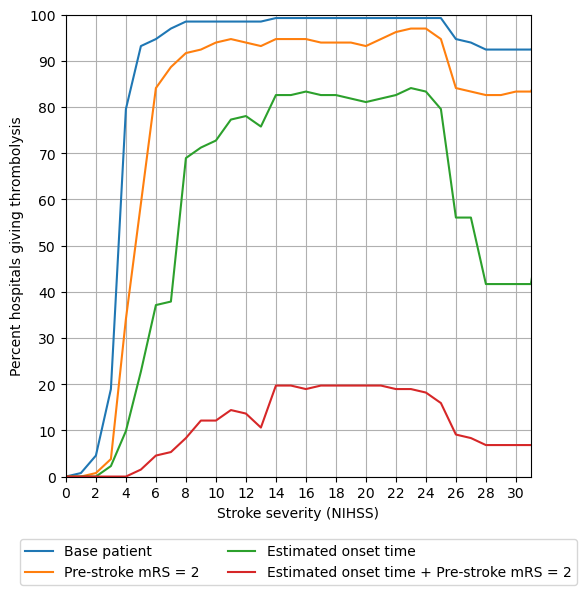

In [26]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()

x = range(len(number_thrombolysing_NIHSS))

y1 = (np.array(control) / number_hopsitals) * 100
ax.plot(x, y1, label = 'Base patient')

y2 = (np.array(disability) / number_hopsitals) * 100
ax.plot(x, y2, label = 'Pre-stroke mRS = 2')

y3 = (np.array(estimated) / number_hopsitals) * 100
ax.plot(x, y3, label = 'Estimated onset time')

y4 = (np.array(disability_estimated) / number_hopsitals) * 100
ax.plot(x, y4, label = 'Estimated onset time + Pre-stroke mRS = 2')


ax.set_xlabel('Stroke severity (NIHSS)')
ax.set_ylabel('Percent hospitals giving thrombolysis')
ax.set_xticks(np.arange(0,31,2))
ax.set_yticks(np.arange(0,101,10))
ax.set_ylim(0,100)
ax.set_xlim(0,31)
ax.grid()
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12),
    fancybox=True, shadow=False, ncol=2)

plt.savefig(f'./output/{notebook}_{model_text}_interactions.jpg', dpi=300, 
            bbox_inches='tight', pad_inches=0.2)
plt.show()